In [1]:
using PyPlot, PyCall
using JLD

INFO: Recompiling stale cache file /Users/chizat/.julia/lib/v0.5/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/chizat/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


In [2]:
include("../src/scalingAlgo.jl")

sa

# I Unbalanced Optimal Transport

## I.1 Convergence speed for fixed $\epsilon$
Let us start with a small illustration of transport in 1d with plots of convergence speed.

In [4]:
I,J = 500, 500                              # number of discretization points
X,Y = linspace(0,1,I), linspace(0,1,J)        # spaces
p,q = sa.example1d(X,Y)                       # densities wrt to Lebesgue
c_array = Float64[(x-y)^2 for x in X, y in Y] # cost matrix
φ1 = Dict(:type => "KL", :param => 1.)        # first divergence
#φ1 = Dict(:type => "RG", :param => [0.5,1.5])
φ2 = φ1
ϵ = 1e-2;

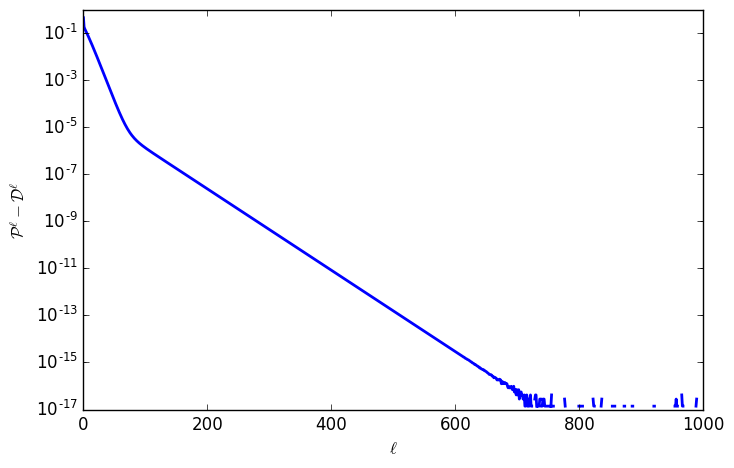

 15.960779 seconds (3.35 M allocations: 15.143 GB, 13.70% gc time)


PyObject <matplotlib.text.Text object at 0x31cc2df50>

  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/chizat/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/chizat/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/chizat/.julia/v0.5/PyCall/sr

In [5]:
@time R,pdgap = sa.simple_unbalancedOT( p, q, φ1, φ2, c_array, ϵ, 1000);

# Plot
fig, ax = subplots(figsize=[8,5],1,1)
semilogy(pdgap,linewidth=2)
ylabel(L"\mathcal{P}^{\ell}-\mathcal{D}^{\ell}")
xlabel(L"\ell")

## 1.2 Transport in 1d
Note that we use a special way to input the spaces (`X` is d-uplet of columns ,`Y` is a d-uplet of rows where d is the dimension)

In [31]:
I,J    = 1000, 1000 #nb of points X,Y
n      = 1            #nb of couplings
X,Y    = linspace(0,1,I), linspace(0,1,J)
dx,dy  = ones(I)/I, ones(J)/J
p,q    = sa.example1d(X,Y) #densities wrt to Lebesgue
#c(x,y) = (y-x).^2
cl(x,y)= -2*log(cospi(0.5*min(1,abs(y-x)/.2)))
F1     = Dict(:type => "KL", :ref => p, :args=>(1.05))
F2     = Dict(:type => "KL", :ref => q, :args=>(1.05))
niter  = 20000
epsvec = logspace(-1.,-7.,20)

@time K, p, q = sa.scalingAlgo(n, F1, F2, cl, (X,), dx, (Y',), dy,niter, epsvec);

23

45678910111213141516171819 12.258459 seconds (81.76 M allocations: 5.538 GB, 5.45% gc time)


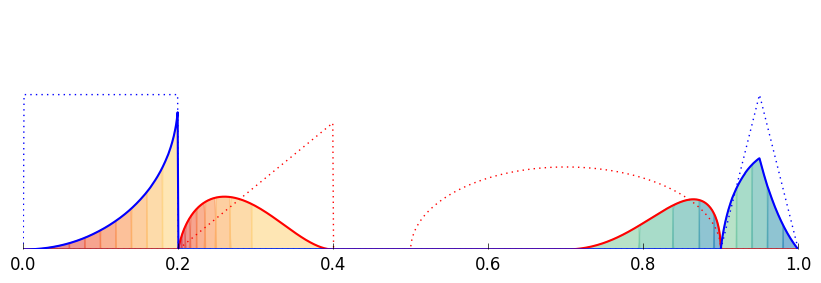

In [32]:
#plots
fig, ax = subplots(figsize=[10,3],1,1)
plot(X,p,":b",alpha=1.);plot(Y,q,":r",alpha=1.);
plot(X,K[1]'*dx,"r",alpha=1.,linewidth=1.5); plot(Y,K[1]*dy,"b",alpha=1.,linewidth=1.5);
nclr = 50
cmap = matplotlib[:cm][:get_cmap]("Spectral") #Set2, Spectral, Paired

for i=1:nclr
    sel = (i-1)/nclr.<= X .< i/nclr
    subK=broadcast(.*,K[1],sel)
    #cl = [i/nclr,mod(i,3)/4,1-mod(i,4)/4] 
    col = pycall(cmap.o, PyAny, mod(1.9*i/nclr,1))
    fill(X,subK'*dx,color=col,alpha=.6)
    fill(Y,subK*dy,color=col, alpha=.6)
end

#tuning
axis([0., 1.,0, 3.1])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](false)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
#savefig("outputs/margs1d_q.pdf")
#fig, ax = subplots(figsize=[5,5],1,1)
#ax = spy(K[1], origin="lower", precision=p, alpha=1., cmap="Blues")

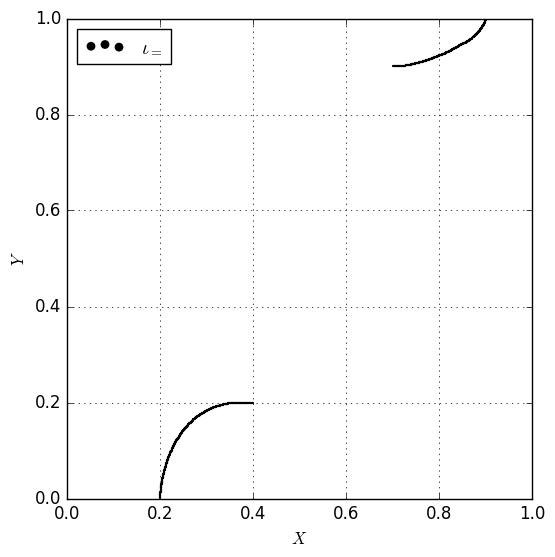

PyObject <matplotlib.axis.XAxis object at 0x321927090>

In [33]:
fig, ax = subplots(figsize=[6,6],1,1)

II,JJ,VV = findnz(K[1].>1e-10)
X,Y=II/I, JJ/J
scatter(Y,X,10,"k",marker=".",linewidths=0.)

legend([L"\iota_{=}",L"0.05\times \, TV",L"0.1\times\, KL",L"RG_{[0.7,1.2]}",L"WF"],markerscale=4,loc=2,numpoints=1)
xlabel(L"X")
ylabel(L"Y")
axis("tight")
axis([0., 1.,0, 1.])
grid("on")
yax= ax[:get_yaxis]()
#yax[:tick_right]()
xax= ax[:get_xaxis]()
#xax[:tick_top]()
#savefig("outputs/plan1d.png")

## I.3 Transport in 2d

In [88]:
# squared domain
n = 1            #nb of coupling
N = 50 # discretization of the domain
I = N^2; 
coord = linspace(0,1,N) 
X1 = repmat(coord,1,N)[:]
X2 = repmat(coord',N,1)[:]
X = (X1,X2)
Y = (X1',X2')
dx,dy  = ones(I)/I, ones(I)/I
c2(x1,x2,y1,y2)=sqrt((x1-y1)^2+(x2-y2)^2)
# Marginals
p,q = sa.example2d(coord,coord)
#p = Float64[ x<.5 for x in coord, y in coord]
#q = Float64[ x>.5 for x in coord, y in coord]
#p=p/sum(p)
#q=q/sum(q)
F1     = Dict(:type => "OT", :ref => p[:], :args=>(.2))
F2     = Dict(:type => "OT", :ref => q[:], :args=>(.2))
niter  = 4000
epsvec = logspace(-1.,-7.,20)

@time K, p, q = sa.scalingAlgo(n, F1, F2, c2, X, dx, Y, dy,niter, epsvec);

23

45678910111213141516171819  6.102974 seconds (329.09 k allocations: 1.338 GB, 7.74% gc time)


In [89]:
γ = zeros(N,N,N,N)
for yb=1:N
    for ya=1:N
        for xb=1:N
            for xa=1:N
                xx = xa + N*(ya-1)
                yy = xb + N*(yb-1)
                γ[xa,ya,xb,yb] = K[1][xx,yy]
            end
        end
    end
end

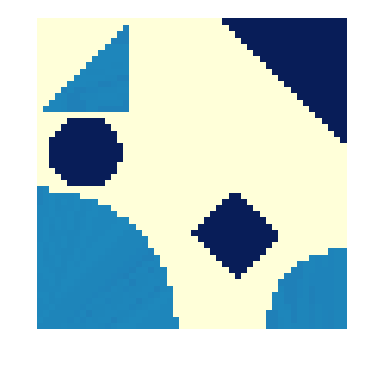

(0.0,50.0,0.0,50.0)

In [90]:
# Display
#R = full(spK[1])
R = full(K[1])
nd = ones(I,I)-diagm(ones(I)) # withdraw "on place" transport coefficients
marg1=reshape((R.*nd)*dy,N,N)
marg2=reshape((R.*nd)'*dx,N,N)
figure(figsize=[4; 4])
#pcolor(p+q,cmap="YlGnBu",vmax=1.5*maximum(q))
pcolormesh(marg1+marg2,cmap="YlGnBu");axis("equal"); axis("off")
axis("equal");axis("off")

In [85]:
L=10
P = zeros(N,N)
Q = zeros(N,N)
clr = randperm(L^2)
for i=0:L-1
    for j = 0:L-1
        IND = Float64[i*div(N,L)<k<=(i+1)*div(N,L) && j*div(N,L)<l<=(j+1)*div(N,L) for k=1:N, l=1:N] #selection
        #M = reshape(R*IND[:].>1e-30,N,N)
        M  = reshape(p,N,N).*IND.>1e-30
        MM = reshape((R.*nd)'*IND[:].>1e-30,N,N)
        P[M]  = 2+clr[i*L+j+1]
        Q[MM] = 2+clr[i*L+j+1]
    end
end

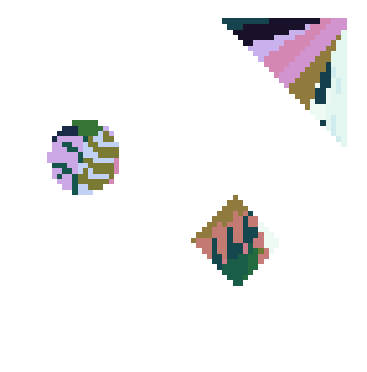

(0.0,60.0,0.0,60.0)

In [86]:
figure(figsize=[4,4])
#subplot(121)
#pcolor(-P,cmap="cubehelix",vmax=0,vmin=-L^2-2); axis("off")#spectral, gnuplot, gnuplot2, gist_ncar, gist_earth, cubehelix
#subplot(122)
pcolor(-Q,cmap="cubehelix",vmax=0,vmin=-L^2-2); axis("off")
#savefig("outputs/map2d_TV.png")

# II. Barycenters

For barycenters in 2d, see the other notebook.

## II.1 Barycenters 1d

Oscillations start to appear when the discretization is very small.

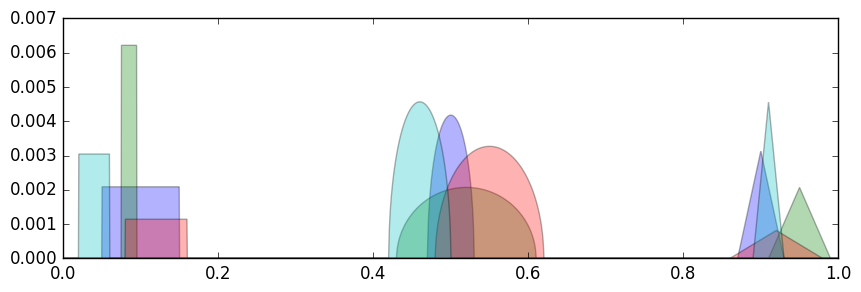

In [45]:
# Parameters
I = 2000;
J = 2000;
# regularization parameters
X, Y = linspace(0,1,I), linspace(0,1,J)  # spatial domain
dx, dy = ones(I)/I, ones(J)/J
c(x,y)=(y-x)^2
clog(x,y)=-2*log(cospi(0.5*min(1,abs(y-x)/.2)))
fgauss(x,p,l) = exp(-((x-p)/l).^2/2)/sqrt(2π*l^2)
frect(x,p,l)  = (-l/2<=x-p<=l/2)
fcirc(x,p,l)  = sqrt(max(0,l^2-(x-p)^2))/l
ftri(x,p,l)   = max(0,min(1+(x-p)/l,1-(x-p)/l))
p = Array{Array}(4)
p[1]  = Float64[ frect(x,0.1,0.1) + 2*fcirc(x,0.5,0.03) + 1.5*ftri(x,0.9,0.03) for x in X];
p[2]  = Float64[ 3*frect(x,0.085,0.02) + fcirc(x,0.52,0.09) + 1*ftri(x,0.95,0.04) for x in X];
p[3]  = Float64[ 0.7*frect(x,0.12,0.08) + 2*fcirc(x,0.55,0.07) + .5*ftri(x,0.92,0.06) for x in X];
p[4]  = Float64[ 2*frect(x,0.04,0.04) + 3*fcirc(x,0.46,0.04) + 3*ftri(x,0.91,0.02) for x in X];

p[1] = p[1] /sum(p[1]); p[2] = p[2]/sum(p[2]); 
p[3] = p[3]/sum(p[3]); p[4] = p[4]/sum(p[4]);
pp = cat(2, p[1][:],p[2][:],p[3][:],p[4][:])

figure(figsize=[10,3])
fill(X,p[1],alpha=.3)
fill(X,p[2],alpha=.3)
fill(X,p[3],alpha=.3)
fill(X,p[4],alpha=.3);

In [46]:
F1     = Dict(:type => "KL", :ref => pp, :weights =>[1.,1.,1.,1.], :args=>(.1))
F2     = Dict(:type => "BaryKL",:weights =>[1.,1.,1.,1.]/4, :args=>(.1))
niter  = 1500
epsvec = logspace(-1.,-5.5,20)

@time K, p, q = sa.scalingAlgo(4, F1, F2, c, (X,), dx, (Y',), dy, niter, epsvec);

2345678910111213141516171819 43.596626 seconds (157.98 M allocations: 10.989 GB, 11.02% gc time)


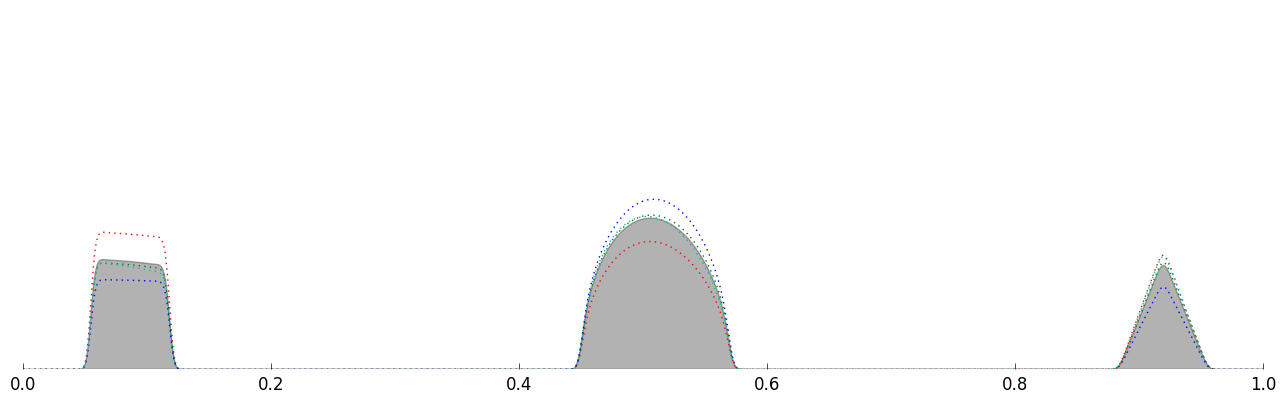

In [48]:
fig, ax = subplots(figsize=[16,4.5],1,1)
ax1 = plot(X,K[1]'*dx,":r",alpha=1.)
plot(X,K[2]'*dx,":g",alpha=1.)
plot(X,K[3]'*dx,":b",alpha=1.)
plot(X,K[4]'*dx,":c",alpha=1.)
#ax1 = plot(X,p[:,1],":r",alpha=1.)
#plot(X,p[:,2],":g",alpha=1.)
#plot(X,p[:,3],":b",alpha=1.)
#plot(X,p[:,4],":c",alpha=1.)
ax1 = fill(X,q[:,1],"k",alpha=.3)

yax = ax[:axes][:get_yaxis]();
yax[:set_visible](false)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
axis([0,1,0,.007]);

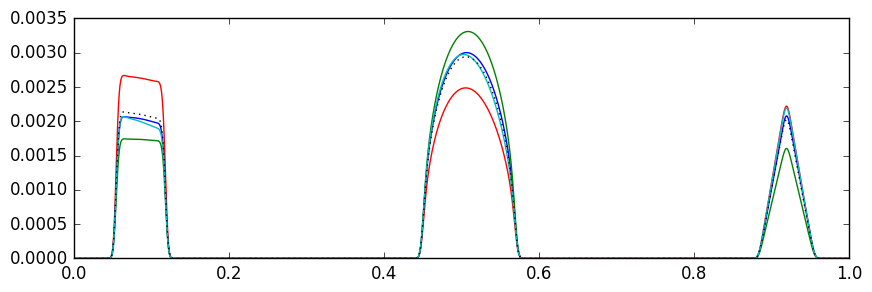

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321114050>

In [49]:
#plot(X,K[2]*dy)
#plot(X,K[1]*dy)
figure(figsize=[10,3])
#plot(X,K[1]'*dy)
plot(X,K[1]'*dy,"r")
plot(X,K[2]'*dy,"b")
plot(X,K[3]'*dy,"g")
plot(X,K[4]'*dy,"c")
#plot(X,K[4]*dy,"b")
#plot(X,K[2]'*dy)
#plot(X,K[3]'*dy)
#plot(X,K[4]'*dy)
plot(X,q[:,1],":k")

# III. Gradient flows

In [50]:
N = 3000;
X = linspace(0,1,N) # spatial domain
c(x,y)=(y-x)^2
gaussian = (x,m,σ) -> exp(-((x-m)/σ).^2/2)/sqrt(2π*σ^2)
p = Float64[1*gaussian(x,.2,.02)+ 2*gaussian(x,.7,.03) for x in X];
p = p./maximum(p)
#p[div(N,2):end]=0
#p[5*div(N,8):6*div(N,8)]=.5
p = max(0,min(1,6*X-.8))
p[3*div(N,7):div(N,2)]=.5
p[div(N,2):3*div(N,4)]=.25
p[4*div(N,7):end]=0
f(x) = max(0,min(1,0.8*(1*x+(1-.8*x)*sin(17*x))))
p[7*div(N,10)+1:end]=[f(x) for x in linspace(0,1,3*div(N,10))]

F1     = Dict(:type => "KL", :ref => pp, :weights =>[1.,1.,1.,1.], :args=>(.1))
F2     = Dict(:type => "BaryKL",:weights =>[1.,1.,1.,1.]/4, :args=>(.1))
niter  = 1500
epsvec = logspace(-1.,-5.,20)

τ,α = 6e-3, 1.
K0 = sparse(1.1*(broadcast(c,X,X').<0.05^2));
nstep=2

@time (flow, pot) = sa.tumor_flow(p[:], τ, α, c, (X,),(X',), nstep, K0;
                  niter = 500, epsvec = logspace(-2,-8,20));

t = 1
t = 

  likely near In[50]:184
  likely near In[50]:184
  likely near In[50]:184
  likely near In[50]:184


2
  7.481479 seconds (24.79 M allocations: 987.061 MB, 3.48% gc time)


## III.1 Tumor growth 1d

In [55]:
N = 3000;
X = linspace(0,1,N) # spatial domain
c(x,y)=(y-x)^2
gaussian = (x,m,σ) -> exp(-((x-m)/σ).^2/2)/sqrt(2π*σ^2)
p = Float64[1*gaussian(x,.2,.02)+ 2*gaussian(x,.7,.03) for x in X];
p = p./maximum(p)
#p[div(N,2):end]=0
#p[5*div(N,8):6*div(N,8)]=.5
p = max(0,min(1,6*X-.8))
p[3*div(N,7):div(N,2)]=.5
p[div(N,2):3*div(N,4)]=.25
p[4*div(N,7):end]=0
f(x) = max(0,min(1,0.8*(1*x+(1-.8*x)*sin(17*x))))
p[7*div(N,10)+1:end]=[f(x) for x in linspace(0,1,3*div(N,10))]


τ,α = 6e-3, 1.
K0 = sparse(1.1*(broadcast(c,X,X').<0.05^2));
nstep=10

@time (flow, pot) = sa.tumor_flow(p[:], τ, α, c, (X,),(X',), nstep, K0;
                  niter = 500, epsvec = logspace(-2,-8,20));

t = 1
t = 

2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
 30.016610 seconds (120.40 M allocations: 4.688 GB, 2.96% gc time)


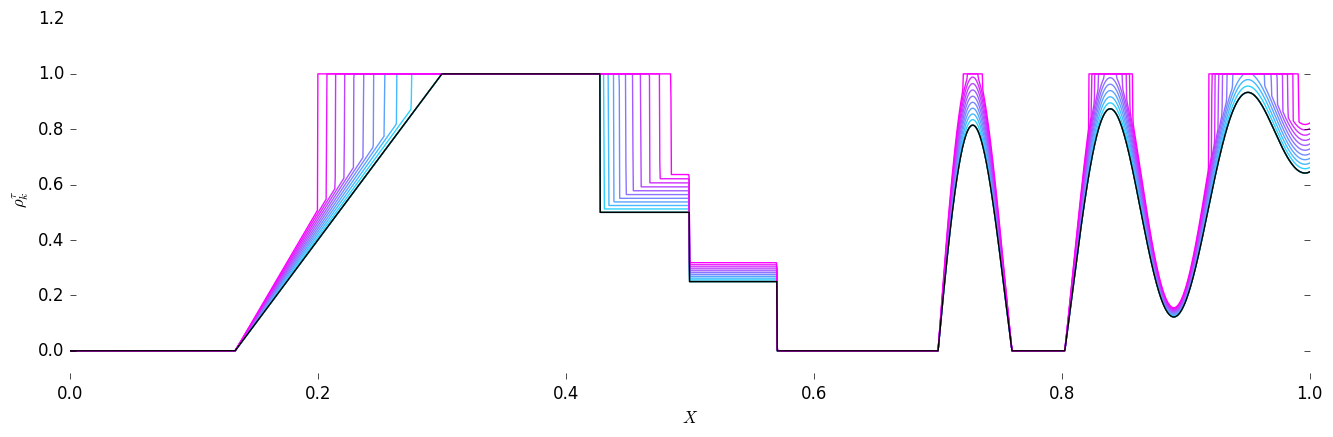

PyObject <matplotlib.text.Text object at 0x320554c50>

In [57]:
fig, ax = subplots(figsize=[16,4.5],1,1)
ax1 = plot(X,flow[1],"k")
NN = length(flow)
for i = 1:1:NN
   plot(X,flow[i],color=[i/NN, 1-i/NN, 1])
end
plot(X,flow[1],"k")

ax[:axis]([0., 1.,-.1, 1.2])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](true)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
xlabel(L"X")
ylabel(L"\rho^{\tau}_k")
#savefig("outputs/heleshaw_profile1d_3000.pdf")

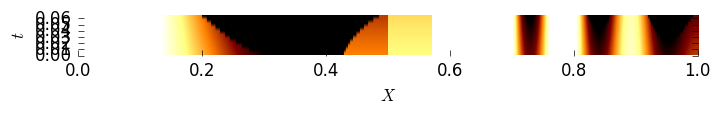

PyObject <matplotlib.text.Text object at 0x3216c6a90>

In [58]:
pp = zeros(length(flow), div(length(flow[1]),1))
for i=1:length(flow)
    pp[i,:]=flow[i]
end
T=length(flow)*τ

fig, ax = subplots(figsize=[8,5],1,1)
imshow(flipdim(pp,1),cmap="afmhot_r", aspect=1.,extent=(0, 1, 0,T))
#ax[:axis]([0., 100.,-.1, 120])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](true)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
xlabel(L"X"); ylabel(L"t")
#savefig("outputs/heleshaw1d_top.png")

## IV. GRADIENT FLOW: tumor growth 2 species

In [ ]:
#include("unbalancedOT.jl")
include("scalingAlgo.jl")
N = 3000;
X = linspace(0,1,N) # spatial domain
c(x,y)=(y-x)^2
pa = Float64[.8*fcirc(x,.2,.2)+.8*fcirc(x,.1,.1)+0.3*fcirc(x,.9,.05) for x in X];
pb = Float64[.8*frect(x,.8,.2)+.8*ftri(x,.7,.2)+.2*frect(x,.9,.2)+.1*fgauss(x,.5,.2) for x in X];
p= [pa[:] pb[:]]/maximum([pa[:]+pb[:]])


τ,α = 4e-3, 1.
K0 = sparse(1.1*(broadcast(c,X,X').<0.05^2));
nstep=60

@time (flow, pot) = sa.tumor2_flow(p, τ, α, c, (X,),(X',), nstep, K0;
                  niter = 1000, epsvec = logspace(-0,-7,20));
#plot(X,p[:,1])
#plot(X,p[:,2])

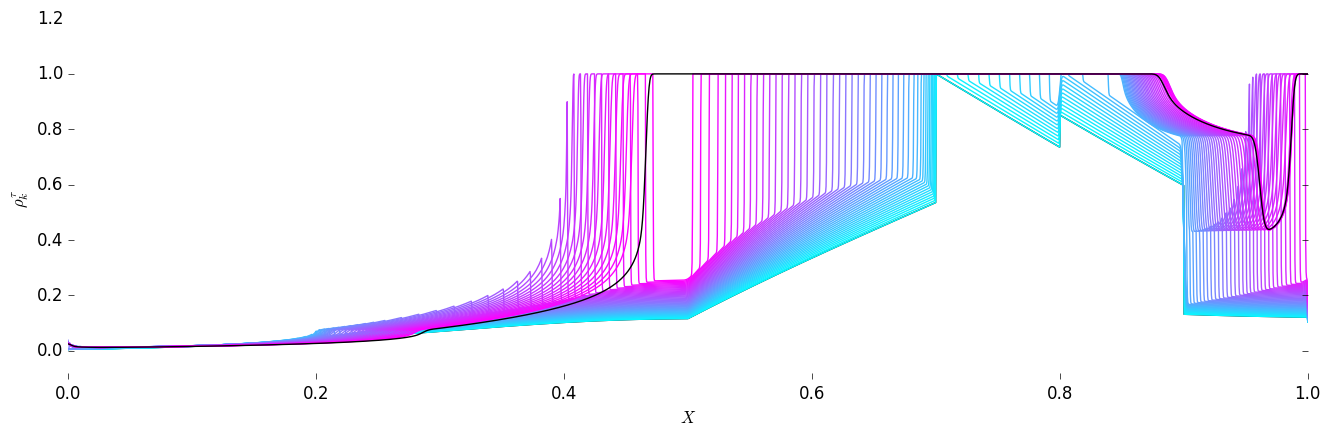

PyObject <matplotlib.text.Text object at 0x31c1b2048>

In [179]:
fig, ax = subplots(figsize=[16,4.5],1,1)
ax1 = plot(X,flow[1][:,2],"k")
NN = 50
for i = 1:1:NN
    plot(X,flow[i][:,2],color=[i/NN, 1-i/NN, 1])
  #  plot(X,flow[i][:,2],color=[i/NN, 1-i/NN, 1])
    #plot(X,flow[i][:,1]+flow[i][:,2],color=[i/NN, 1-i/NN, 1])
end
plot(X,flow[end][:,2],"k")
#plot(X,flow[1][:,2],"k")
#plot(X,flow[1][:,1]+flow[1][:,2],"k")

ax[:axis]([0., 1.,-.1, 1.2])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](true)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
xlabel(L"X") 
ylabel(L"\rho^{\tau}_k")
#savefig("outputs/heleshaw_profile1d_3000.pdf")

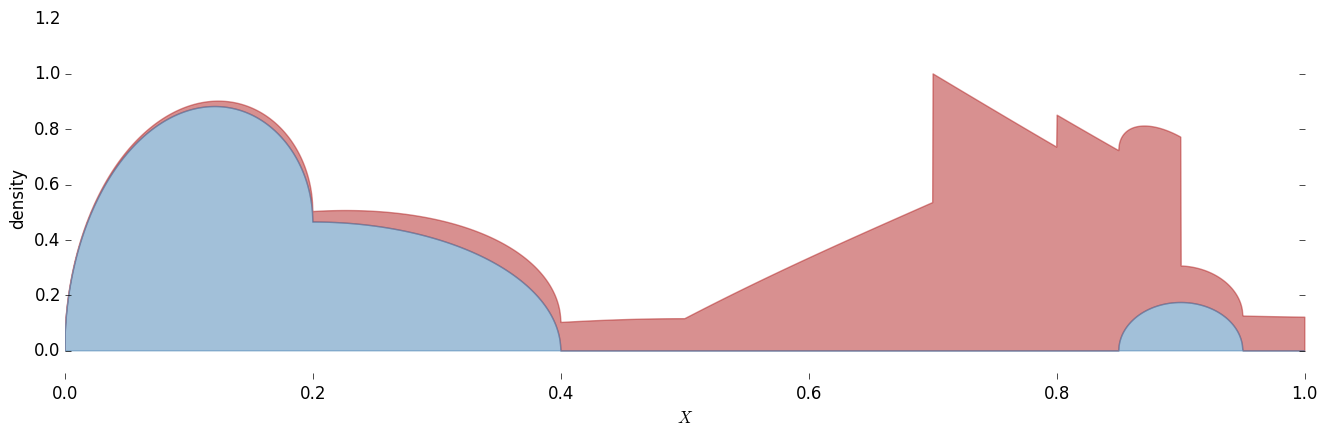

In [190]:
#fill(X,flow[1][:,1],"k")
#fill_between(X,flow[1][:,1],flow[1][:,2]+flow[1][:,1])
fig, ax = subplots(figsize=[16,4.5],1,1)
ax1 = fill(X,[0;flow[1][2:end-1,1];0],color="SteelBlue",alpha=0.5)
fill_between(X,flow[1][:,1],flow[1][:,2]+flow[1][:,1],color="FireBrick",alpha=0.5)
ax[:axis]([0., 1.,-.1, 1.2])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](true)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
xlabel(L"X") 
ylabel("density")
savefig("outputs/GFgrowth2_profile1d_t0.pdf")


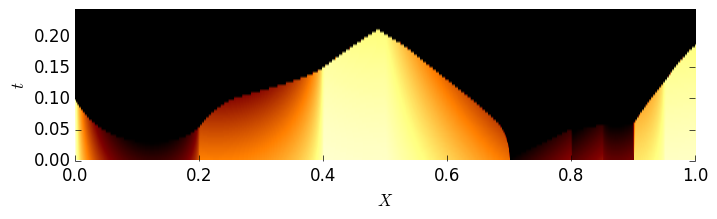

In [199]:
NN=length(flow)
pp = zeros(NN, div(size(flow[1],1),1))
for i=1:NN
    pp[i,:]=flow[i][:,1]
end
T=NN*τ

fig, ax = subplots(figsize=[8,5],1,1)
imshow(flipdim(pp,1),cmap="afmhot_r", aspect=1.,extent=(0, 1, 0,T))
#ax[:axis]([0., 100.,-.1, 120])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](true)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()
xlabel(L"X"); ylabel(L"t")
#savefig("outputs/GFgrowth2_1d_topsum.png")